In [1]:
from aicsimageio import AICSImage
from tifffile import imsave
from pathlib import Path
import numpy as np
from skimage.filters import threshold_otsu
from skimage.morphology import ball, binary_closing, remove_small_objects, dilation, erosion, disk
from aicssegmentation.core.pre_processing_utils import  intensity_normalization, edge_preserving_smoothing_3d
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.core.seg_dot import dot_2d
from aicssegmentation.core.utils import topology_preserving_thinning, hole_filling
import matplotlib.pyplot as plt
import pandas as pd
from itkwidgets import view   
import seaborn as sns
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
plt.rcParams["figure.figsize"] = [16, 12]

<h3> Initial Overall Validation (v5 data) <h3>

In [5]:
filepaths_50ms_v5 = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-50ms-ex1v5.tiff",
                    "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-50ms-ex2v5.tiff",
                    "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-50ms-ex3v5.tiff",
                    "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-50ms-ex5v5.tiff"]
volumes_50ms_v5 = []

for filename in filepaths_50ms_v5:
    # read file
    reader = AICSImage(filename) 
    IMG50 = reader.data.astype(np.float32)
    # calculate volume
    volume50 = np.sum(IMG50)
    volumes_50ms_v5.append(volume50)
    
volumes_50ms_v5  


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[20473.0, 14681.0, 29616.0, 21807.0]

In [7]:
filepaths_200ms_v5 = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex1v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex2v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex3v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex5v5.tiff"]
volumes_200ms_v5 = []

for filename in filepaths_200ms_v5:
    # read file
    reader = AICSImage(filename) 
    IMG200 = reader.data.astype(np.float32)
    # calculate volume
    volume200 = np.sum(IMG200)
    volumes_200ms_v5.append(volume200)
    
volumes_200ms_v5

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[3917.0, 7834.0, 12551.0, 9019.0]

In [10]:
filepaths_tf200ms_v5 = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex1v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex2v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex3v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex5v5.tiff"]

volumes_tf200ms_v5 = []

for filename in filepaths_tf200ms_v5:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMGtf200 = reader.data.astype(np.float32)
    # calculate volume
    volumetf200 = np.sum(IMGtf200)
    volumes_tf200ms_v5.append(volumetf200)
    
volumes_tf200ms_v5


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[4911.0, 7807.0, 15060.0, 6990.0]

In [11]:
import pandas as pd
# create a dataframe with all the info 
data_v5 = {'50ms_volumes_v5': volumes_50ms_v5,
        '200ms_volumes_v5': volumes_200ms_v5,
        'tf200ms_volumes_v5': volumes_tf200ms_v5}

volumes_v5 = pd.DataFrame(data_v5)
volumes_v5

,50ms_volumes_v5,200ms_volumes_v5,tf200ms_volumes_v5
0,20473.0,3917.0,4911.0
1,14681.0,7834.0,7807.0
2,29616.0,12551.0,15060.0
3,21807.0,9019.0,6990.0


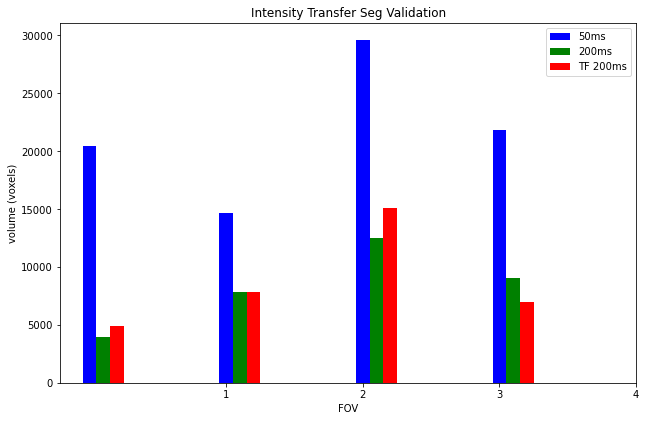

In [12]:
# plot volumes against each other 
#figure(figsize=(8, 6), dpi=80)
fig, ax = plt.subplots(figsize=(8,5))

X = np.arange(4)
ax = fig.add_axes([0,0,1,1])

ax.bar(X, volumes_v5['50ms_volumes_v5'], color='b', width = 0.10)
ax.bar(X + 0.10, volumes_v5['200ms_volumes_v5'], color='g', width = 0.10)
ax.bar(X +0.20, volumes_v5['tf200ms_volumes_v5'], color= 'r', width = 0.10)

plt.xlabel('FOV')
plt.ylabel('volume (voxels)')
plt.title('Intensity Transfer Seg Validation')
ax.legend(['50ms','200ms', 'TF 200ms'])

ax.xaxis.set_ticklabels = (['FOV1', 'FOV2', 'FOV3', 'FOV4'])
ax.xaxis.set_ticks([1,2,3,4])

plt.show()

<h3> Initial Overall Validation (v3 data) <h3>

In [ ]:
filepaths_200ms = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-imgs/seg/golgi-200ms-ex1v3.tiff",
                  "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-imgs/seg/golgi-200ms-ex2v3.tiff",
                  "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-imgs/seg/golgi-200ms-ex4v3.tiff",
                  "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-imgs/seg/golgi-200ms-ex5v3.tiff"]

volumes_200ms = []

for filename in filepaths_200ms:
    # read file
    reader = AICSImage(filename) 
    IMG200 = reader.data.astype(np.float32)
    # calculate volume
    volume200 = np.sum(IMG200)
    volumes_200ms.append(volume200)
    
volumes_200ms

In [2]:
filepaths_50ms_v5 = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-50ms-imgs/seg/golgi-50ms-ex1v3.tiff",
              "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-50ms-imgs/seg/golgi-50ms-ex2v3.tiff",
              "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-50ms-imgs/seg/golgi-50ms-ex3v3.tiff",
                 "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-50ms-imgs/seg/golgi-50ms-ex5v3.tiff"]
volumes_50ms_v5 = []

for filename in filepaths_50ms:
    # read file
    reader = AICSImage(filename) 
    IMG50 = reader.data.astype(np.float32)
    # calculate volume
    volume50 = np.sum(IMG50)
    volumes_50ms.append(volume50)
    
volumes_50ms   

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[5533.0, 3663.0, 8780.0, 5473.0]

In [3]:
filepaths_200ms = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-imgs/seg/golgi-200ms-ex1v3.tiff",
                  "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-imgs/seg/golgi-200ms-ex2v3.tiff",
                  "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-imgs/seg/golgi-200ms-ex4v3.tiff",
                  "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-imgs/seg/golgi-200ms-ex5v3.tiff"]

volumes_200ms = []

for filename in filepaths_200ms:
    # read file
    reader = AICSImage(filename) 
    IMG200 = reader.data.astype(np.float32)
    # calculate volume
    volume200 = np.sum(IMG200)
    volumes_200ms.append(volume200)
    
volumes_200ms

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[2427.0, 6881.0, 4890.0, 6146.0]

In [4]:
filepaths_tf200ms = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-imgs/seg/golgi-tf200ms-ex1v3.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-imgs/seg/golgi-tf200ms-ex2v3.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-imgs/seg/golgi-tf200ms-ex4v3.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-imgs/seg/golgi-tf200ms-ex5v3.tiff"
    
]

volumes_tf200ms = []

for filename in filepaths_tf200ms:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMGtf200 = reader.data.astype(np.float32)
    # calculate volume
    volumetf200 = np.sum(IMGtf200)
    volumes_tf200ms.append(volumetf200)
    
volumes_tf200ms


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[7256.0, 12572.0, 12663.0, 10397.0]

In [5]:
volumes_tf200ms_v7 = [2087, 3793, 6161, 4214]

In [5]:
filepaths_tf200ms_v5 = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex1v6.tiff",
                      "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex2v6.tiff",
                        "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex3v6.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex5v6.tiff"]

volumes_tf200ms_v5 = []

for filename in filepaths_tf200ms_v5:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMGtf200_v5 = reader.data.astype(np.float32)
    # calculate volume
    volumetf200_v5 = np.sum(IMGtf200_v5)
    volumes_tf200ms_v5.append(volumetf200_v5)
    
volumes_tf200ms_v5

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[2943.0, 6001.0, 9745.0, 3787.0]

In [6]:
import pandas as pd
# create a dataframe with all the info 
data = {'50ms_volumes': volumes_50ms,
        '200ms_volumes': volumes_200ms,
        'tf200ms_volumes': volumes_tf200ms,
       'tf200ms_volumesV7': volumes_tf200ms_v7}

volume_df = pd.DataFrame(data)
volume_df

,50ms_volumes,200ms_volumes,tf200ms_volumes,tf200ms_volumesV7
0,5533.0,2427.0,7256.0,2087
1,3663.0,6881.0,12572.0,3793
2,8780.0,4890.0,12663.0,6161
3,5473.0,6146.0,10397.0,4214


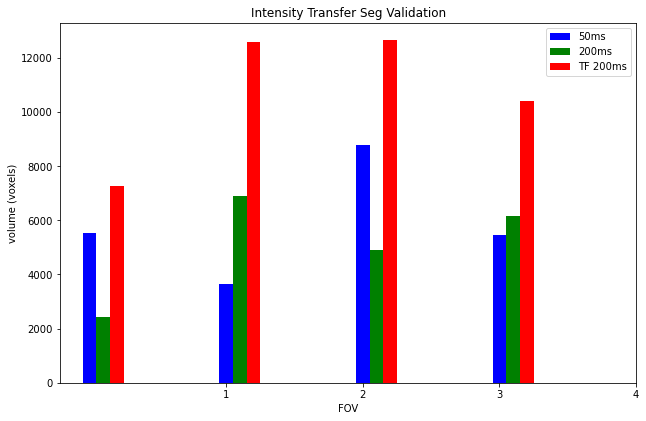

In [7]:
# plot volumes against each other 
#figure(figsize=(8, 6), dpi=80)
fig, ax = plt.subplots(figsize=(8,5))

X = np.arange(4)
ax = fig.add_axes([0,0,1,1])

ax.bar(X, volume_df['50ms_volumes'], color='b', width = 0.10)
ax.bar(X + 0.10, volume_df['200ms_volumes'], color='g', width = 0.10)
ax.bar(X +0.20, volume_df['tf200ms_volumes'], color= 'r', width = 0.10)

plt.xlabel('FOV')
plt.ylabel('volume (voxels)')
plt.title('Intensity Transfer Seg Validation')
ax.legend(['50ms','200ms', 'TF 200ms'])

ax.xaxis.set_ticklabels = (['FOV1', 'FOV2', 'FOV3', 'FOV4'])
ax.xaxis.set_ticks([1,2,3,4])

plt.show()

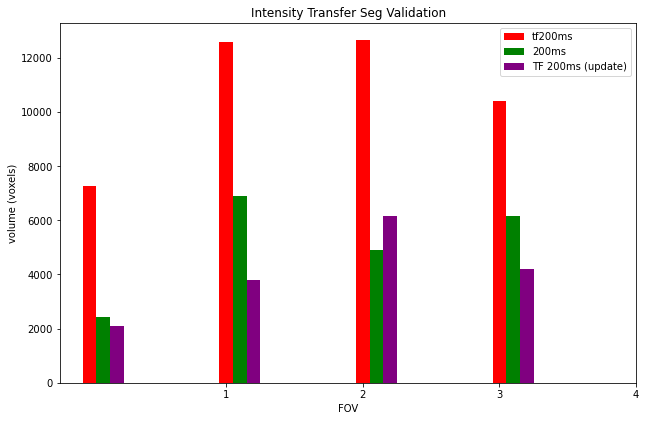

In [14]:
# plot volumes against each other 
#figure(figsize=(8, 6), dpi=80)
fig, ax = plt.subplots(figsize=(8,5))

X = np.arange(4)
ax = fig.add_axes([0,0,1,1])

ax.bar(X, volume_df['tf200ms_volumes'], color='r', width = 0.10)
ax.bar(X + 0.10, volume_df['200ms_volumes'], color='g', width = 0.10)
ax.bar(X +0.20, volume_df['tf200ms_volumesV7'], color= 'purple', width = 0.10)

plt.xlabel('FOV')
plt.ylabel('volume (voxels)')
plt.title('Intensity Transfer Seg Validation')
ax.legend(['tf200ms','200ms', 'TF 200ms (update)'])

ax.xaxis.set_ticklabels = (['FOV1', 'FOV2', 'FOV3', 'FOV4'])
ax.xaxis.set_ticks([1,2,3,4])

plt.show()

In [98]:
B = "//allen/aics/assay-dev/users/Benji/Sandwich_Block7_TF/golgi_ch=1_50ms/valid/5500000635_EE_1-01_AcquisitionBlock7_pt7_Scene-4_aligned.ome.tiff"
B

'//allen/aics/assay-dev/users/Benji/Sandwich_Block7_TF/golgi_ch=1_50ms/valid/5500000635_EE_1-01_AcquisitionBlock7_pt7_Scene-4_aligned.ome.tiff'

<h2> 2D Spot Filter Validation <h2>

In [19]:
spotfilter_50_imgs = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-50ms-ex1-spotfilter-25.tiff"]

spotfilter_200_imgs = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex1-spotfilter-25.tiff"]

spotfilter_tf200_imgs = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex1-spotfilter-25.tiff"]

In [20]:
spotfilter_50ms = []
for filename in spotfilter_50_imgs:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMG_spotfilter = reader.data.astype(np.float32)
    # calculate volume
    vol_spotfilter = np.sum(IMG_spotfilter)
    spotfilter_50ms.append(vol_spotfilter)
    
spotfilter_200ms = []
for filename in spotfilter_200_imgs:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMG_spotfilter = reader.data.astype(np.float32)
    # calculate volume
    vol_spotfilter = np.sum(IMG_spotfilter)
    spotfilter_200ms.append(vol_spotfilter)
    
spotfilter_tf200ms = []
for filename in spotfilter_tf200_imgs:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMG_spotfilter = reader.data.astype(np.float32)
    # calculate volume
    vol_spotfilter = np.sum(IMG_spotfilter)
    spotfilter_tf200ms.append(vol_spotfilter)

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


In [21]:
print(spotfilter_50ms, spotfilter_200ms, spotfilter_tf200ms)

[10136.0] [1030.0] [2271.0]


In [22]:
# create a dataframe with all the info 
spotfilter_data = {'50ms_spotfilter': spotfilter_50ms,
                  '200ms_spotfilter': spotfilter_200ms,
                  'tf200ms_spotfilter': spotfilter_tf200ms}

spotfilter_volumes = pd.DataFrame(spotfilter_data)
spotfilter_volumes

,50ms_spotfilter,200ms_spotfilter,tf200ms_spotfilter
0,10136.0,1030.0,2271.0


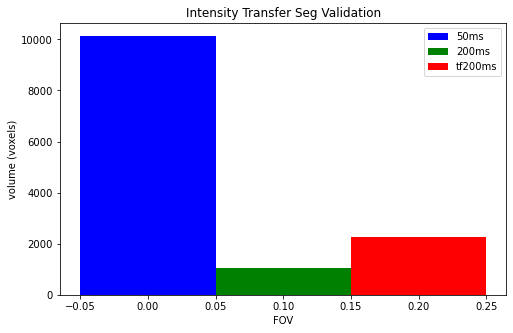

In [29]:
# plot volumes against each other 

fig, ax = plt.subplots(figsize=(8,5))

X = np.arange(1)
#ax = fig.add_axes([0,0,1,1])

ax.bar(X, spotfilter_volumes['50ms_spotfilter'], color='b', width = 0.10)
ax.bar(X+0.10, spotfilter_volumes['200ms_spotfilter'], color='g', width = 0.10)
ax.bar(X+0.20 , spotfilter_volumes['tf200ms_spotfilter'], color= 'r', width = 0.10)

plt.xlabel('FOV')
plt.ylabel('volume (voxels)')
plt.title('Intensity Transfer Seg Validation')
ax.legend(['50ms','200ms', 'tf200ms'])

#ax.xaxis.set_ticklabels = (['FOV1', 'FOV2', 'FOV3', 'FOV4'])
#ax.xaxis.set_ticks([1,2,3,4])

plt.show()

<h3> Spot Filter/Erosion Thinning GridSearch Results <h3> 

In [4]:
# parameter sweep results 

spotfilter_vals = [0.05, 0.05, 0.05, 0.05, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15, 0.15, 0.15, 0.2, 0.2, 0.2, 0.2]
erosion_vals = [0.5, 1.0, 1.5, 2.0, 0.5, 1.0, 1.5, 2.0, 0.5, 1.0, 1.5, 2.0, 0.5, 1.0, 1.5, 2.0]
v5_50ms_results = [16988, 16353, 16353, 16353, 16455, 15618, 15618, 15618, 15024, 15024, 15024, 15024, 16078, 14805, 14805,
               14805]
v5_200ms_results = [3514, 3334, 3334, 3334, 2917, 2497, 2497, 2497, 2545, 1829, 1829, 1829, 2354, 1408, 1408, 1405]

In [5]:
results_dict = {'spot_filter': spotfilter_vals,
               'erosion_thin': erosion_vals,
               '50ms_ex1': v5_50ms_results,
               '200ms_ex1': v5_200ms_results}

results_df = pd.DataFrame(results_dict)
results_df.head()

,spot_filter,erosion_thin,50ms_ex1,200ms_ex1
0,0.05,0.5,16988,3514
1,0.05,1.0,16353,3334
2,0.05,1.5,16353,3334
3,0.05,2.0,16353,3334
4,0.10,0.5,16455,2917


In [6]:
error = abs(results_df['50ms_ex1'] - results_df['200ms_ex1'])
results_df['error'] = error

In [7]:
results_df.head()

,spot_filter,erosion_thin,50ms_ex1,200ms_ex1,error
0,0.05,0.5,16988,3514,13474
1,0.05,1.0,16353,3334,13019
2,0.05,1.5,16353,3334,13019
3,0.05,2.0,16353,3334,13019
4,0.10,0.5,16455,2917,13538


In [8]:
error_results = results_df[['spot_filter', 'erosion_thin','error']]
error_results

,spot_filter,erosion_thin,error
0,0.05,0.5,13474
1,0.05,1.0,13019
2,0.05,1.5,13019
3,0.05,2.0,13019
4,0.10,0.5,13538
5,0.10,1.0,13121
6,0.10,1.5,13121
7,0.10,2.0,13121
8,0.15,0.5,12479
9,0.15,1.0,13195


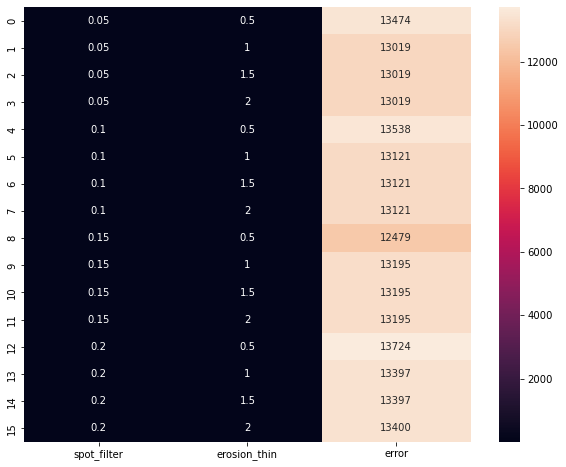

In [9]:
# create a heatmap 
import seaborn as sns

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(error_results, annot = True, fmt='g')
plt.show()

In [10]:
flights_long = sns.load_dataset("flights")

In [11]:
flights_long

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


<AxesSubplot:xlabel='erosion_thin', ylabel='spot_filter'>

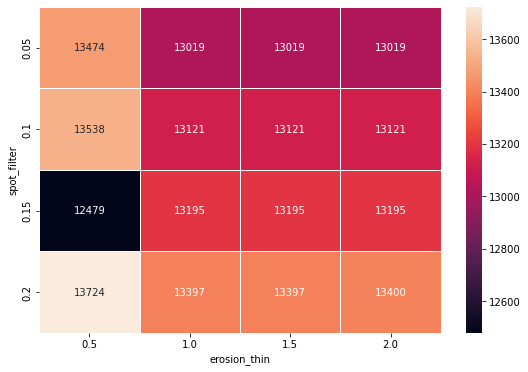

In [28]:
error_results2 = error_results.pivot("spot_filter", "erosion_thin", "error")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(error_results2, annot=True, fmt="d", linewidths=.5, ax=ax)

<h3> Otsu Thresholding Grid Search Results <h3>

In [17]:
otsu_thresh_vals = [2.8, 3.8, 4.8, 5.8, 6.8]
v5_50ms_results = [6689, 6366, 6355, 2880, 2302]
v5_200ms_results = [3917, 6237, 6338, 6354, 6355]

otsu_dict = {'otsu_thresh_vals':otsu_thresh_vals,
             'v5_50ms_results':v5_50ms_results,
             'v5_200ms_results':v5_200ms_results}

otsu_errors = pd.DataFrame(otsu_dict)
otsu_errors.head()         

,otsu_thresh_vals,v5_50ms_results,v5_200ms_results
0,2.8,6689,3917
1,3.8,6366,6237
2,4.8,6355,6338
3,5.8,2880,6354
4,6.8,2302,6355


In [21]:
error2 = abs(otsu_errors['v5_50ms_results'] - otsu_errors['v5_200ms_results'])
otsu_errors['error'] = error2
otsu_errors['otsu_thresh_vals2'] = otsu_thresh_vals
otsu_errors.head()

,otsu_thresh_vals,v5_50ms_results,v5_200ms_results,error,otsu_thresh_vals2
0,2.8,6689,3917,2772,2.8
1,3.8,6366,6237,129,3.8
2,4.8,6355,6338,17,4.8
3,5.8,2880,6354,3474,5.8
4,6.8,2302,6355,4053,6.8


<AxesSubplot:xlabel='otsu_thresh_vals2', ylabel='otsu_thresh_vals'>

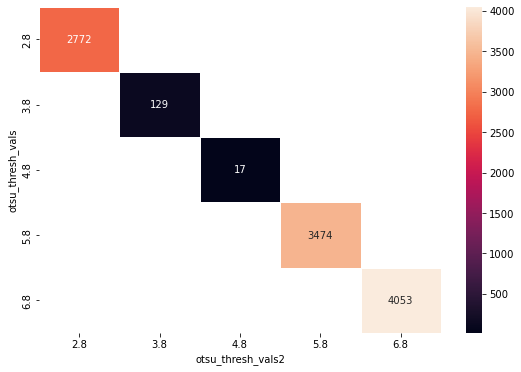

In [27]:
otsu_errors2 = otsu_errors.pivot("otsu_thresh_vals", "otsu_thresh_vals2", "error")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(otsu_errors2, annot=True, fmt='g', linewidths=.5, ax=ax)

<h2> V6 Validation Results <h2> 

In [31]:
filepaths_50ms_v6 = ["C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex1v6.tiff",
                    "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex2v6.tiff",
                    "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex3v6.tiff",
                    "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex5v6.tiff"]
volumes_50ms_v6 = []

for filename in filepaths_50ms_v6:
    # read file
    reader = AICSImage(filename) 
    IMG50 = reader.data.astype(np.float32)
    # calculate volume
    volume50 = np.sum(IMG50)
    volumes_50ms_v6.append(volume50)
    
volumes_50ms_v6 

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[3532.0, 2912.0, 5907.0, 3616.0]

In [32]:
filepaths_200ms_v6 = ["C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex1v6.tiff",
                     "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex2v6.tiff",
                      "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex3v6.tiff",
                     "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex5v6.tiff"]

volumes_200ms_v6 = []

for filename in filepaths_200ms_v6:
    # read file
    reader = AICSImage(filename) 
    IMG200 = reader.data.astype(np.float32)
    # calculate volume
    volume200 = np.sum(IMG200)
    volumes_200ms_v6.append(volume200)
    
volumes_200ms_v6

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[3580.0, 7009.0, 10780.0, 7640.0]

In [33]:
filepaths_tf200ms_v6 = ["C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex1v6.tiff",
                       "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex2v6.tiff",
                       "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex3v6.tiff",
                       "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex5v6.tiff"]

volumes_tf200ms_v6 = []

for filename in filepaths_tf200ms_v6:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMGtf200 = reader.data.astype(np.float32)
    # calculate volume
    volumetf200 = np.sum(IMGtf200)
    volumes_tf200ms_v6.append(volumetf200)
    
volumes_tf200ms_v6

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[9992.0, 18258.0, 31826.0, 21015.0]

In [34]:
# create a dataframe with all the info 
data = {'50ms_volumesV6': volumes_50ms_v6,
        '200ms_volumesV6': volumes_200ms_v6,
        'tf200ms_volumesV6': volumes_tf200ms_v6}

volumeV6_df = pd.DataFrame(data)
volumeV6_df

,50ms_volumesV6,200ms_volumesV6,tf200ms_volumesV6
0,3532.0,3580.0,9992.0
1,2912.0,7009.0,18258.0
2,5907.0,10780.0,31826.0
3,3616.0,7640.0,21015.0


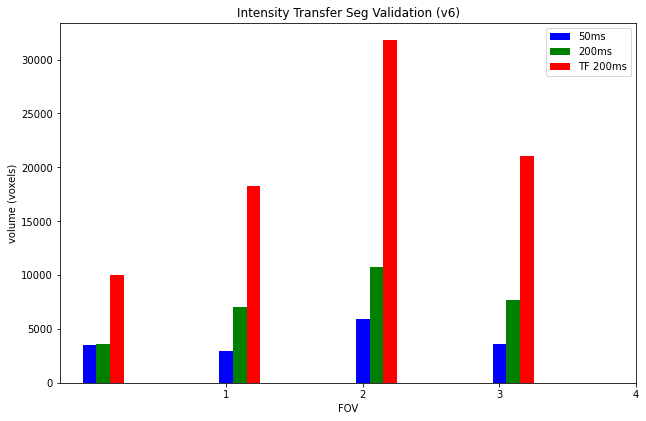

In [37]:
# plot volumes against each other 
fig, ax = plt.subplots(figsize=(8,5))

X = np.arange(4)
ax = fig.add_axes([0,0,1,1])

ax.bar(X, volumeV6_df['50ms_volumesV6'], color='b', width = 0.10)
ax.bar(X + 0.10, volumeV6_df['200ms_volumesV6'], color='g', width = 0.10)
ax.bar(X +0.20, volumeV6_df['tf200ms_volumesV6'], color= 'r', width = 0.10)

plt.xlabel('FOV')
plt.ylabel('volume (voxels)')
plt.title('Intensity Transfer Seg Validation (v6)')
ax.legend(['50ms','200ms', 'TF 200ms'])

ax.xaxis.set_ticklabels = (['FOV1', 'FOV2', 'FOV3', 'FOV4'])
ax.xaxis.set_ticks([1,2,3,4])

plt.show()

In [5]:
# RESULTS PART 1
ex1_50v6_volume = [3326,1823,938,519,1084,754,565,409,1063,751,565,409,1063,751,565,409,1063,751,565,409]
ex1_200v6_volume = [2404,1583,1118,792,2403,1583,1118,792,2403,1583,1118,792,2403,1583,1118,792,2403,1583,1118,792]
spotfilter_vals = [0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.03,0.03,0.03,0.03,0.04,0.04,0.04,0.04,0.05,0.05,0.05,0.05]
erosion_vals = [0.28,0.38,0.48,0.58,0.28,0.38,0.48,0.58,0.28,0.38,0.48,0.58,0.28,0.38,0.48,0.58,0.28,0.38,0.48,0.58]


gridsearchv6_dict = {'spot_filter_vals':spotfilter_vals,
                     'erosion_thin_vals':erosion_vals,
                     'ex1_50ms_volume':ex1_50v6_volume,
                     'ex1_200ms_volume':ex1_200v6_volume}

# print(len(ex1_50v6_volume), len(ex1_200v6_volume), len(spotfilter_vals), len(erosion_vals))
gridsearchv6_df = pd.DataFrame(gridsearchv6_dict)

v6_errors = abs(gridsearchv6_df['ex1_50ms_volume'] - gridsearchv6_df['ex1_200ms_volume'])
gridsearchv6_df['error'] = v6_errors
gridsearchv6_df.head()

,spot_filter_vals,erosion_thin_vals,ex1_50ms_volume,ex1_200ms_volume,error
0,0.01,0.28,3326,2404,922
1,0.01,0.38,1823,1583,240
2,0.01,0.48,938,1118,180
3,0.01,0.58,519,792,273
4,0.02,0.28,1084,2403,1319


In [13]:
# RESULTS PART 2

ex1_50v6_volume2 = [6843,5107,4031,3356,2841,6843,5107,4031,3356,2841,6843,5107,4031,3356,2841,6843,5107,4031,3356,2841,6843,
                  5107,4031,3356,2841]
ex1_200v6_volume2 = [5608,3612,2406,1712,1322,4341,2929,2144,1630,1301,4339,2929,2144,1630,1301,4339,2929,2144,1630,1301,4339,
                    2929,2144,1630,1301]
spotfilter_vals2 = [0.005,0.005,0.005,0.005,0.005,0.006,0.006,0.006,0.006,0.006,0.007,0.007,0.007,0.007,0.007,0.008,0.008,0.008,
                   0.008,0.008,0.009,0.009,0.009,0.009,0.009]
erosion_vals2 = [0.08,0.12,0.16,0.20,0.24,0.08,0.12,0.16,0.20,0.24,0.08,0.12,0.16,0.20,0.24,0.08,0.12,0.16,0.20,0.24,
                 0.08,0.12,0.16,0.20,0.24,]


gridsearchv6_dict2 = {'spot_filter_vals':spotfilter_vals2,
                     'erosion_thin_vals':erosion_vals2,
                     'ex1_50ms_volume':ex1_50v6_volume2,
                     'ex1_200ms_volume':ex1_200v6_volume2}

# print(len(ex1_50v6_volume), len(ex1_200v6_volume), len(spotfilter_vals), len(erosion_vals))
gridsearchv6_df2 = pd.DataFrame(gridsearchv6_dict2)

v6_errors2 = abs(gridsearchv6_df2['ex1_50ms_volume'] - gridsearchv6_df2['ex1_200ms_volume'])
gridsearchv6_df2['error'] = v6_errors2
gridsearchv6_df2

,spot_filter_vals,erosion_thin_vals,ex1_50ms_volume,ex1_200ms_volume,error
0,0.005,0.08,6843,5608,1235
1,0.005,0.12,5107,3612,1495
2,0.005,0.16,4031,2406,1625
3,0.005,0.20,3356,1712,1644
4,0.005,0.24,2841,1322,1519
5,0.006,0.08,6843,4341,2502
6,0.006,0.12,5107,2929,2178
7,0.006,0.16,4031,2144,1887
8,0.006,0.20,3356,1630,1726
9,0.006,0.24,2841,1301,1540


<AxesSubplot:xlabel='erosion_thin_vals', ylabel='spot_filter_vals'>

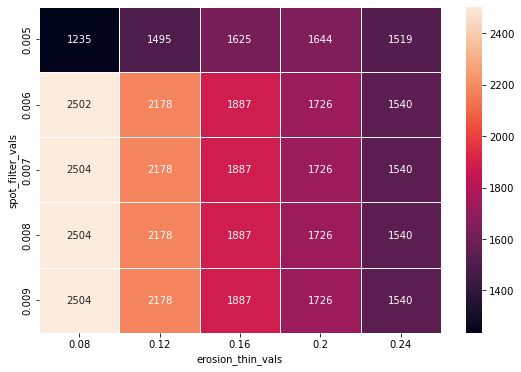

In [7]:
gridsearchv6_df2 = gridsearchv6_df2.pivot("spot_filter_vals", "erosion_thin_vals", "error")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(gridsearchv6_df2, annot=True, fmt="d", linewidths=.5, ax=ax)

<h3> 50ms V7 Volumes <h3>

In [33]:
volume_check_paths = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex1v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex1v5.tiff",
                     "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex1v7.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex2v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex2v5.tiff",
                     "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex2v7.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex3v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex3v5.tiff",
                     "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex3v7.tiff",
                      "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex5v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex5v5.tiff",
                     "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex5v7.tiff"]
volumes_check = []

for filename in volume_check_paths:
    # read file
    reader = AICSImage(filename) 
    IMG = reader.data.astype(np.float32)
    # calculate volume
    volumeIMG = np.sum(IMG)
    volumes_check.append(volumeIMG)
    
volumes_check

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[3917.0,
 4911.0,
 6460.0,
 7834.0,
 7807.0,
 5025.0,
 12551.0,
 15060.0,
 10888.0,
 9019.0,
 6990.0,
 7067.0]

In [35]:
filepaths_50ms_v7 = ["C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex1v7.tiff",
                      "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex2v7.tiff",
                       "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex3v7.tiff",
                      "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex5v7.tiff"]

volumes_50ms_v7 = []

for filename in filepaths_50ms_v7:
    # read file
    reader = AICSImage(filename) 
    IMG50 = reader.data.astype(np.float32)
    # calculate volume
    volume50 = np.sum(IMG50)
    volumes_50ms_v7.append(volume50)
    
volumes_50ms_v7  

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[6460.0, 5025.0, 10888.0, 7067.0]

In [36]:
filepaths_200ms_v5 = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex1v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex2v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex3v5.tiff",
                     "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-200ms-ex5v5.tiff"]
volumes_200ms_v5 = []

for filename in filepaths_200ms_v5:
    # read file
    reader = AICSImage(filename) 
    IMG200 = reader.data.astype(np.float32)
    # calculate volume
    volume200 = np.sum(IMG200)
    volumes_200ms_v5.append(volume200)
    
volumes_200ms_v5

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[3917.0, 7834.0, 12551.0, 9019.0]

In [38]:
filepaths_tf200ms_v5 = ["//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex1v5.tiff",
                       "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex2v5.tiff",
                       "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex3v5.tiff",
                       "//allen/aics/assay-dev/users/Sandi/aics-segmentation/lookup_table_demo/golgi-tf200ms-ex5v5.tiff"]

volumes_tf200ms_v5 = []

for filename in filepaths_tf200ms_v5:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMGtf200_v5 = reader.data.astype(np.float32)
    # calculate volume
    volumetf200_v5 = np.sum(IMGtf200_v5)
    volumes_tf200ms_v5.append(volumetf200_v5)
    
volumes_tf200ms_v5

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[4911.0, 7807.0, 15060.0, 6990.0]

In [41]:
# create a dataframe with all the info 
data_v7 = {'50ms_volumes_v7': volumes_50ms_v7,
        '200ms_volumes_v5': volumes_200ms_v5,
        'tf200ms_volumes_v5': volumes_tf200ms_v5}

volumes_v7 = pd.DataFrame(data_v7)
volumes_v7

,50ms_volumes_v7,200ms_volumes_v5,tf200ms_volumes_v5
0,6460.0,3917.0,4911.0
1,5025.0,7834.0,7807.0
2,10888.0,12551.0,15060.0
3,7067.0,9019.0,6990.0


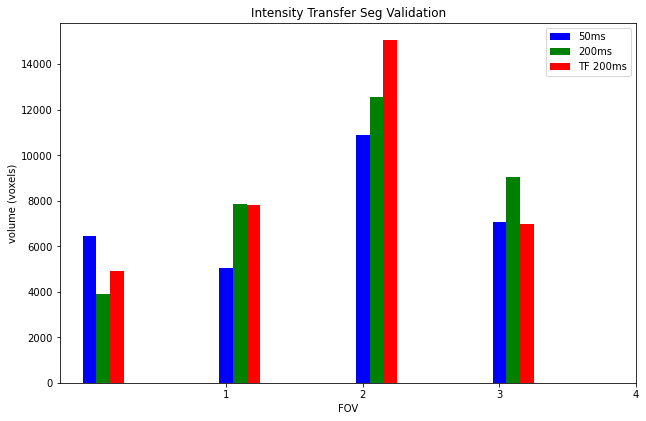

In [43]:
# plot volumes against each other 
fig, ax = plt.subplots(figsize=(8,5))

X = np.arange(4)
ax = fig.add_axes([0,0,1,1])

ax.bar(X, volumes_v7['50ms_volumes_v7'], color='b', width = 0.10)
ax.bar(X + 0.10, volumes_v7['200ms_volumes_v5'], color='g', width = 0.10)
ax.bar(X +0.20, volumes_v7['tf200ms_volumes_v5'], color= 'r', width = 0.10)

plt.xlabel('FOV')
plt.ylabel('volume (voxels)')
plt.title('Intensity Transfer Seg Validation')
ax.legend(['50ms','200ms', 'TF 200ms'])

ax.xaxis.set_ticklabels = (['FOV1', 'FOV2', 'FOV3', 'FOV4'])
ax.xaxis.set_ticks([1,2,3,4])

plt.show()

<h3> Updated v5 Runs 200/TF200 11/18 <h3>

In [55]:
filepaths_200ms_v5 = ["C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex1v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex2v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex3v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex5v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex6v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex7v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex8v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex9v5.tiff"]

filepaths_tf200ms_v5 = ["C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex1v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex2v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex3v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex5v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex6v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex7v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex8v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex9v5.tiff"]

volumes_200ms_v5 = []

for filename in filepaths_200ms_v5:
    # read file
    reader = AICSImage(filename) 
    IMG200 = reader.data.astype(np.float32)
    # calculate volume
    volume200 = np.sum(IMG200)
    volumes_200ms_v5.append(volume200)
    
volumes_200ms_v5

volumes_tf200ms_v5 = []

for filename in filepaths_tf200ms_v5:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMGtf200_v5 = reader.data.astype(np.float32)
    # calculate volume
    volumetf200_v5 = np.sum(IMGtf200_v5)
    volumes_tf200ms_v5.append(volumetf200_v5)
    
volumes_tf200ms_v5

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[6677.0, 5986.0, 6572.0, 12633.0]

In [79]:
filepaths_50ms_v5 = ["C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex2v7.tiff",
                     "C:\Users\sandra.oluoch\Desktop\slurm-down\golgi-50ms-ex3v5.tiff",
                     "C:\Users\sandra.oluoch\Desktop\slurm-down\golgi-50ms-ex5v5.tiff",
                     "C:\Users\sandra.oluoch\Desktop\slurm-down\golgi-50ms-ex7v5.tiff",
                     "C:\Users\sandra.oluoch\Desktop\slurm-down\golgi-50ms-ex8v5.tiff"
                     
                     "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex7v5.tiff",
                    "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex8v7.tiff"]
volumes_50ms_v5 = []

for filename in filepaths_50ms_v5:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMG50_v5 = reader.data.astype(np.float32)
    # calculate volume
    volume50_v5 = np.sum(IMG50_v5)
    volumes_50ms_v5.append(volume50_v5)
    
volumes_50ms_v5

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[5025.0, 5578.0, 1768.0]

In [80]:
volumes_50ms_v5 = [5025, 5347, 9148,11546]

In [77]:
# create a dataframe with all the info 
data_200s_v5 = {'200ms_volumes_v5': volumes_200ms_v5,
               'tf200ms_volumes_v5': volumes_tf200ms_v5,
               '50ms_volumes_v5': volumes_50ms_v5}

volumes_200s_v5 = pd.DataFrame(data_200s_v5)
volumes_200s_v5

,200ms_volumes_v5,tf200ms_volumes_v5,50ms_volumes_v5
0,6824.0,6677.0,5025
1,7009.0,5986.0,5347
2,7612.0,6572.0,9148
3,10286.0,12633.0,11546


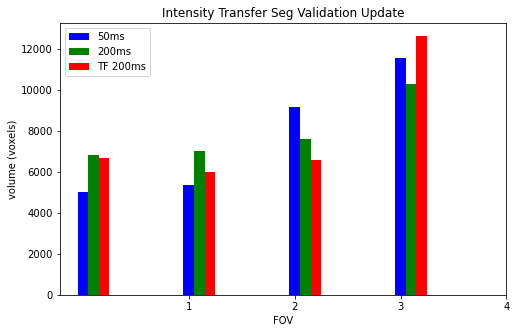

In [84]:
# plot volumes against each other 
fig, ax = plt.subplots(figsize=(8,5))

X = np.arange(4)
#ax = fig.add_axes([0,0,1,1])

ax.bar(X, volumes_200s_v5['50ms_volumes_v5'], color='b', width = 0.10)
ax.bar(X + 0.10, volumes_200s_v5['200ms_volumes_v5'], color='g', width = 0.10)
ax.bar(X +0.20, volumes_200s_v5['tf200ms_volumes_v5'], color= 'r', width = 0.10)

plt.xlabel('FOV')
plt.ylabel('volume (voxels)')
plt.title('Intensity Transfer Seg Validation Update')
ax.legend(['50ms','200ms', 'TF 200ms'])

ax.xaxis.set_ticklabels = (['FOV1', 'FOV2', 'FOV3', 'FOV4'])
ax.xaxis.set_ticks([1,2,3,4])

plt.show()

<h3> Segmentation Results Nov 20th <h3>

In [93]:
filepaths_50ms_nov20 = ["C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex1v5.tiff",
                     "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex2v5.tiff",
                        "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex3v5.tiff",
                        "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex5v5.tiff",
                        "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex6v5.tiff",
                      "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex7v5.tiff",
                      "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex8v5.tiff",
                      "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex9v5.tiff",
                      "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex10v5.tiff",
                      "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex11v5.tiff",
                     "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-50ms-ex12v5.tiff"]

volumes_50ms_nov20 = []

for filename in filepaths_50ms_nov20:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMG50_nov20 = reader.data.astype(np.float32)
    # calculate volume
    volume50_nov20 = np.sum(IMG50_nov20)
    volumes_50ms_nov20.append(volume50_nov20)
    
volumes_50ms_nov20

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[6455.0,
 5024.0,
 10880.0,
 7061.0,
 186.0,
 5578.0,
 2386.0,
 1901.0,
 9966.0,
 13284.0,
 11796.0]

In [94]:
filepaths_200ms_nov20 = ["C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex1v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex2v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex3v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex5v5check.tiff",
 "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex6v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex7v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex8v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex9v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex10v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex11v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-200ms-ex12v5.tiff"]

volumes_200ms_nov20 = []

for filename in filepaths_200ms_nov20:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMG200_nov20 = reader.data.astype(np.float32)
    # calculate volume
    volume200_nov20 = np.sum(IMG200_nov20)
    volumes_200ms_nov20.append(volume200_nov20)
    
volumes_200ms_nov20


Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[2404.0,
 6824.0,
 8812.0,
 6030.0,
 504.0,
 7009.0,
 7612.0,
 10286.0,
 2252.0,
 4075.0,
 4018.0]

In [90]:
filepaths_tf200ms_nov20 = ["C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex1v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex2v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex3v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex5v5check.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex6v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex7v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex8v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex9v5.tiff",
"C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex10v5.tiff",
 "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex11v5.tiff",
 "C:/Users/sandra.oluoch/Desktop/slurm-down/golgi-tf200ms-ex12v5.tiff"]

volumes_tf200ms_nov20 = []

for filename in filepaths_tf200ms_nov20:
    # read file
    reader = AICSImage(filename, dir_order="ZYX") 
    IMGtf200_nov20 = reader.data.astype(np.float32)
    # calculate volume
    volumetf200_nov20 = np.sum(IMGtf200_nov20)
    volumes_tf200ms_nov20.append(volumetf200_nov20)
    
volumes_tf200ms_nov20

Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0
Failed to parse XML for the provided file. Error: not well-formed (invalid token): line 1, column 0


[7029.0,
 6677.0,
 20217.0,
 9950.0,
 5593.0,
 5986.0,
 6572.0,
 14559.0,
 15342.0,
 14559.0,
 20723.0]

In [96]:
# create a dataframe with all the info 
data_nov20 = {'50ms_volumes': volumes_50ms_nov20,
            '200ms_volumes': volumes_200ms_nov20,
            'tf200ms_volumes': volumes_tf200ms_nov20}

volumes_nov20 = pd.DataFrame(data_nov20)
volumes_nov20

,50ms_volumes,200ms_volumes,tf200ms_volumes
0,6455.0,2404.0,7029.0
1,5024.0,6824.0,6677.0
2,10880.0,8812.0,20217.0
3,7061.0,6030.0,9950.0
4,186.0,504.0,5593.0
5,5578.0,7009.0,5986.0
6,2386.0,7612.0,6572.0
7,1901.0,10286.0,14559.0
8,9966.0,2252.0,15342.0
9,13284.0,4075.0,14559.0


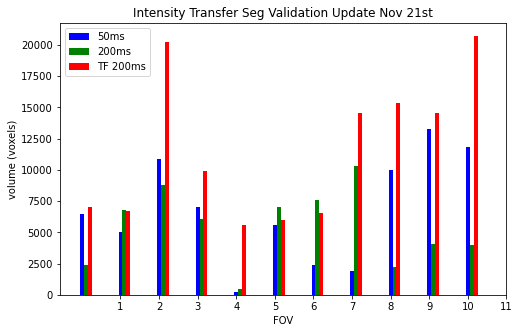

In [97]:
# plot volumes against each other 
fig, ax = plt.subplots(figsize=(8,5))

X = np.arange(11)
#ax = fig.add_axes([0,0,1,1])

ax.bar(X, volumes_nov20['50ms_volumes'], color='b', width = 0.10)
ax.bar(X + 0.10, volumes_nov20['200ms_volumes'], color='g', width = 0.10)
ax.bar(X +0.20, volumes_nov20['tf200ms_volumes'], color= 'r', width = 0.10)

plt.xlabel('FOV')
plt.ylabel('volume (voxels)')
plt.title('Intensity Transfer Seg Validation Update Nov 21st')
ax.legend(['50ms','200ms', 'TF 200ms'])

#ax.xaxis.set_ticklabels = (['FOV1', 'FOV2', 'FOV3', 'FOV4',])
ax.xaxis.set_ticks([1,2,3,4,5,6,7,8,9,10,11])

plt.show()

<h3> V8.1 Jaccard Index Validation <h3>

In [117]:
golgi_50ms_volv8 = [3525,2909,6816,5892,3604]
golgi_200ms_volv8 = [3519,6816,2909,10531,7462]



1760.9987223168655

<h3> Example 6 Spot Filter/Erosion Thinning <h3> 

In [5]:
# Example 6 Grid Search Results 

ex6_50ms_volumes = [217,189,175,169,217,189,175,169,217,189,175,169,217,189,175,169,217,189,175,169]
ex6_200ms_volumes = [504,355,301,284,504,355,301,284,504,355,301,284,504,355,301,284,504,355,301,284,]
spot_filter_vals = [0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.02,0.03,0.03,0.03,0.03,0.04,0.04,0.04,0.04,0.05,0.05,0.05,0.05]
erosion_thin_vals = [0.28,0.38,0.48,0.58,0.28,0.38,0.48,0.58,0.28,0.38,0.48,0.58,0.28,0.38,0.48,0.58,0.28,0.38,0.48,0.58]

ex6_vol_dict = {'50ms': ex6_50ms_volumes,
             '200ms':ex6_200ms_volumes,
             'spot_filter':spot_filter_vals,
             'erosion_thin_vals':erosion_thin_vals}
ex6_vol_df = pd.DataFrame(ex6_vol_dict)
ex6_vol_df.head()


,50ms,200ms,spot_filter,erosion_thin_vals
0,217,504,0.01,0.28
1,189,355,0.01,0.38
2,175,301,0.01,0.48
3,169,284,0.01,0.58
4,217,504,0.02,0.28


In [6]:
ex6_errors = abs(ex6_vol_df['50ms'] - ex6_vol_df['200ms'])
ex6_vol_df['error'] = ex6_errors

ex6_vol_df.head()

,50ms,200ms,spot_filter,erosion_thin_vals,error
0,217,504,0.01,0.28,287
1,189,355,0.01,0.38,166
2,175,301,0.01,0.48,126
3,169,284,0.01,0.58,115
4,217,504,0.02,0.28,287


<AxesSubplot:xlabel='erosion_thin_vals', ylabel='spot_filter'>

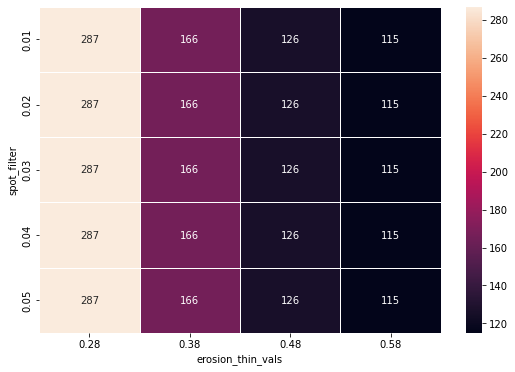

In [7]:
ex6_vol_df = ex6_vol_df.pivot("spot_filter","erosion_thin_vals","error")

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(ex6_vol_df, annot=True, fmt='d',linewidths=.5, ax=ax)

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(gridsearchv6_df2, annot=True, fmt="d", linewidths=.5, ax=ax)